In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim
from torch.distributions import Categorical

from models import SimpleClassifier
from models import DifficultyEstimator

In [ ]:
# A Gymnasium environment that simulates curriculum learning for a classifier.
class CurriculumEnv(gym.Env):
    def __init__(self, embeddings, labels, device, difficulty_bins=10, 
                 history_length=5, max_steps=1000, batch_size=8):
        super().__init__()
        self.embeddings = embeddings
        self.labels = labels
        self.device = device
        self.n_samples = len(embeddings)
        self.max_steps = max_steps
        self.batch_size = batch_size
        
        # Pre-compute difficulty scores for all samples
        self.difficulties = self._compute_initial_difficulties()
        
        # Divide samples into difficulty bins
        self.n_bins = difficulty_bins
        self.difficulty_bins = self._create_difficulty_bins()
        
        self.classifier = SimpleClassifier()
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-4)
        
        self.step_count = 0
        self.total_reward = 0.0
        self.training_history = deque(maxlen=history_length)  # Store recent losses
        self.sample_usage = np.zeros(self.n_samples)  # Track how often each sample is used
        
        # Define action and observation spaces
        # Action: Select difficulty bin (0 to n_bins-1)
        self.action_space = gym.spaces.Discrete(self.n_bins)
        
        # Observation: [progress, avg_recent_loss, loss_trend, sample_diversity]
        self.observation_space = gym.spaces.Box(
            low=np.array([0.0, 0.0, -1.0, 0.0], dtype=np.float32),
            high=np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )
        
        self.last_avg_loss = 1.0
        self.validation_performance = 0.0
        
        # Create validation set (10% of data)
        self._create_validation_set()

    # Compute initial difficulty scores for all samples
    def _compute_initial_difficulties(self):
        temp_classifier = SimpleClassifier()
        temp_classifier.to(self.device)
        temp_classifier.eval()
        
        difficulties = []
        batch_size = 64
        
        with torch.no_grad():
            for i in range(0, self.n_samples, batch_size):
                batch_indices = slice(i, min(i + batch_size, self.n_samples))
                x_batch = self.embeddings[batch_indices].to(self.device)
                y_batch = self.labels[batch_indices].to(self.device)
                
                outputs = temp_classifier(x_batch)
                
                losses = F.cross_entropy(outputs, y_batch, reduction='none')
                
                difficulties.extend(losses.cpu().numpy())
        
        difficulties = np.array(difficulties)
        difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min() + 1e-8)
        
        return difficulties

    # Divide samples into bins based on their difficulty scores
    def _create_difficulty_bins(self):
        bins = [[] for _ in range(self.n_bins)]
        bin_edges = np.linspace(0, 1, self.n_bins + 1)
        
        for i, difficulty in enumerate(self.difficulties):
            # Find which bin this sample belongs to
            for bin_idx in range(self.n_bins):
                if bin_edges[bin_idx] <= difficulty < bin_edges[bin_idx + 1]:
                    bins[bin_idx].append(i)
                    break
            # Handle edge case for difficulty = 1.0
            if difficulty == 1.0:
                bins[-1].append(i)
        
        return bins

    # Create a small validation set to evaluate model performance
    def _create_validation_set(self):
        val_size = int(0.1 * self.n_samples)
        val_indices = np.random.choice(self.n_samples, val_size, replace=False)
        
        self.val_mask = np.zeros(self.n_samples, dtype=bool)
        self.val_mask[val_indices] = True
        
        self.train_mask = ~self.val_mask
        self.train_indices = np.where(self.train_mask)[0]

    # Get the current environment observation
    def _get_obs(self):
        # Progress through episode
        progress = self.step_count / self.max_steps
        
        if len(self.training_history) > 0:
            avg_recent_loss = np.mean(self.training_history)
            avg_recent_loss = min(avg_recent_loss, 1.0)
        else:
            avg_recent_loss = 1.0
        
        if len(self.training_history) >= 2:
            # Average of first half vs second half of history
            half_idx = len(self.training_history) // 2
            first_half = np.mean(list(self.training_history)[:half_idx])
            second_half = np.mean(list(self.training_history)[half_idx:])
            loss_trend = np.clip((second_half - first_half) * 5, -1, 1)
        else:
            loss_trend = 0.0
        
        # Calculate sample diversity (entropy of sample usage)
        if np.sum(self.sample_usage) > 0:
            usage_probs = self.sample_usage / np.sum(self.sample_usage)
            non_zero = usage_probs > 0
            entropy = -np.sum(usage_probs[non_zero] * np.log(usage_probs[non_zero]))
            max_entropy = np.log(min(self.step_count + 1, self.n_samples))
            if max_entropy > 0:
                sample_diversity = min(entropy / max_entropy, 1.0)
            else:
                sample_diversity = 0.0
        else:
            sample_diversity = 0.0
        
        return np.array([
            progress,
            avg_recent_loss,
            loss_trend,
            sample_diversity
        ], dtype=np.float32)

    # Evaluate the classifier on the validation set
    def _evaluate_validation_performance(self):
        self.classifier.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            batch_size = 64
            val_indices = np.where(self.val_mask)[0]
            
            for i in range(0, len(val_indices), batch_size):
                batch_idx = val_indices[i:i + batch_size]
                x_val = self.embeddings[batch_idx].to(self.device)
                y_val = self.labels[batch_idx].to(self.device)
                
                outputs = self.classifier(x_val)
                _, predicted = torch.max(outputs, 1)
                
                total += y_val.size(0)
                correct += (predicted == y_val).sum().item()
        
        accuracy = correct / total if total > 0 else 0
        return accuracy
    
    # Reset the environment to start a new episode
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Reset classifier and optimizer
        self.classifier = SimpleClassifier().to(self.device)
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-4)
        
        # Reset environment state
        self.step_count = 0
        self.total_reward = 0.0
        self.training_history.clear()
        self.sample_usage = np.zeros(self.n_samples)
        self.last_avg_loss = 1.0
        self.validation_performance = 0.0
        
        # Re-create validation set with a new random split
        self._create_validation_set()
        
        return self._get_obs(), {}

    # Take a step in the environment given the action
    def step(self, action):
        action = int(action)
        if action < 0 or action >= self.n_bins:
            raise ValueError(f"Invalid action: {action}. Must be between 0 and {self.n_bins-1}")
        
        # Get samples from the selected difficulty bin
        bin_indices = self.difficulty_bins[action]
        if not bin_indices:
            # If bin is empty, use random samples
            train_indices = np.random.choice(self.train_indices, 
                                           min(self.batch_size, len(self.train_indices)), 
                                           replace=False)
        else:
            valid_indices = [idx for idx in bin_indices if not self.val_mask[idx]]
            if not valid_indices:
                train_indices = np.random.choice(self.train_indices, 
                                               min(self.batch_size, len(self.train_indices)), 
                                               replace=False)
            else:
                train_indices = np.random.choice(valid_indices, 
                                               min(self.batch_size, len(valid_indices)), 
                                               replace=False)
        
        # Record which samples were used
        for idx in train_indices:
            self.sample_usage[idx] += 1
        
        # Get the embeddings and labels for the selected samples
        x_batch = self.embeddings[train_indices].to(self.device)
        y_batch = self.labels[train_indices].to(self.device)
        
        # Measure performance before training
        self.classifier.eval()
        with torch.no_grad():
            outputs_before = self.classifier(x_batch)
            loss_before = F.cross_entropy(outputs_before, y_batch).item()
            _, predicted_before = torch.max(outputs_before, 1)
            accuracy_before = (predicted_before == y_batch).float().mean().item()
        
        # Train on the selected samples
        self.classifier.train()
        self.optimizer.zero_grad()
        outputs = self.classifier(x_batch)
        loss = F.cross_entropy(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        
        # Measure performance after training
        self.classifier.eval()
        with torch.no_grad():
            outputs_after = self.classifier(x_batch)
            loss_after = F.cross_entropy(outputs_after, y_batch).item()
            _, predicted_after = torch.max(outputs_after, 1)
            accuracy_after = (predicted_after == y_batch).float().mean().item()
        
        # Update training history
        self.training_history.append(loss_after)
        
        # Calculate reward components
        loss_improvement = loss_before - loss_after
        accuracy_improvement = accuracy_after - accuracy_before
        
        # Every 10 steps, evaluate on validation set
        info = {}
        if self.step_count % 10 == 0:
            current_val_performance = self._evaluate_validation_performance()
            val_improvement = current_val_performance - self.validation_performance
            self.validation_performance = current_val_performance
            info['validation_accuracy'] = current_val_performance
        else:
            val_improvement = 0.0
        
        # Construct a more meaningful reward
        # 1. Loss improvement on the batch
        # 2. Accuracy improvement on the batch
        # 3. Improvement on validation set (when measured)
        reward = (loss_improvement * 2.0 + 
                  accuracy_improvement * 5.0 + 
                  val_improvement * 10.0)
        
        # Update state
        self.step_count += 1
        self.total_reward += reward
        
        done = self.step_count >= self.max_steps
        
        info.update({
            'loss_before': loss_before,
            'loss_after': loss_after,
            'accuracy_before': accuracy_before,
            'accuracy_after': accuracy_after,
            'loss_improvement': loss_improvement,
            'accuracy_improvement': accuracy_improvement,
            'difficulty_level': action,
            'total_reward': self.total_reward
        })
        
        return self._get_obs(), reward, done, False, info

    # Render the environment state
    def render(self):
        val_acc = self._evaluate_validation_performance()
        print(f"Step: {self.step_count}/{self.max_steps} | "
              f"Total Reward: {self.total_reward:.4f} | "
              f"Recent Loss: {np.mean(self.training_history):.4f} | "
              f"Validation Acc: {val_acc:.4f}")

    # Update difficulty scores based on current model performance
    def update_difficulties(self):
        self.classifier.eval()
        new_difficulties = []
        
        with torch.no_grad():
            batch_size = 64
            for i in range(0, self.n_samples, batch_size):
                batch_indices = slice(i, min(i + batch_size, self.n_samples))
                x_batch = self.embeddings[batch_indices].to(self.device)
                y_batch = self.labels[batch_indices].to(self.device)
                
                # Forward pass
                outputs = self.classifier(x_batch)
                
                # Calculate loss for each sample
                losses = F.cross_entropy(outputs, y_batch, reduction='none')
                
                # Get softmax probabilities
                probs = F.softmax(outputs, dim=1)
                correct_probs = probs[torch.arange(len(y_batch)), y_batch]
                
                # Difficulty is a combination of loss and inverse confidence
                sample_difficulties = losses.cpu().numpy() * (1 - correct_probs.cpu().numpy())
                new_difficulties.extend(sample_difficulties)
        
        new_difficulties = np.array(new_difficulties)
        new_difficulties = (new_difficulties - new_difficulties.min()) / (
            new_difficulties.max() - new_difficulties.min() + 1e-8)
        
        self.difficulties = new_difficulties
        
        self.difficulty_bins = self._create_difficulty_bins()
        
        return new_difficulties

In [ ]:
# Memory buffer for PPO algorithm to store experiences
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return (
            np.array(self.states),
            np.array(self.actions),
            np.array(self.probs),
            np.array(self.vals),
            np.array(self.rewards),
            np.array(self.dones),
            batches
        )

# Actor network for PPO - selects difficulty levels
class ActorNetwork(nn.Module):
    def __init__(self, input_dims, n_actions, alpha=0.0003):
        super(ActorNetwork, self).__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(input_dims, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Softmax(dim=-1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

# Critic network for PPO - evaluates states
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha=0.0003):
        super(CriticNetwork, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(input_dims, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        
        return value

# PPO Agent defintions
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, gae_lambda=0.95,
                 clip_eps=0.2, epochs=10, batch_size=64):
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size

        self.actor = ActorNetwork(state_dim, action_dim, lr)
        self.critic = CriticNetwork(state_dim, lr)
        self.memory = PPOMemory(batch_size)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.actor.device)
        dist = self.actor(state)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)
        return action.item(), log_prob.item(), value.item()

    def store_transition(self, state, action, log_prob, value, reward, done):
        self.memory.store_memory(state, action, log_prob, value, reward, done)

    def learn(self):
        mem = self.memory
        states, actions, old_probs, values, rewards, dones, batches = mem.generate_batches()

        states = torch.tensor(states, dtype=torch.float).to(self.actor.device)
        actions = torch.tensor(actions).to(self.actor.device)
        old_probs = torch.tensor(old_probs, dtype=torch.float).to(self.actor.device)
        values = torch.tensor(values, dtype=torch.float).to(self.actor.device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(self.actor.device)
        dones = torch.tensor(dones, dtype=torch.float).to(self.actor.device)

        returns = []
        adv = []
        discounted = 0
        for t in reversed(range(len(rewards))):
            mask = 1.0 - dones[t]
            delta = rewards[t] + self.gamma * values[t + 1] * mask - values[t] if t < len(rewards) - 1 else rewards[t] - values[t]
            discounted = delta + self.gamma * self.gae_lambda * mask * discounted
            adv.insert(0, discounted)
            ret = discounted + values[t]
            returns.insert(0, ret)

        adv = torch.tensor(adv, dtype=torch.float).to(self.actor.device)
        returns = torch.tensor(returns, dtype=torch.float).to(self.actor.device)
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(self.epochs):
            for batch in batches:
                b_states = states[batch]
                b_actions = actions[batch]
                b_old_probs = old_probs[batch]
                b_returns = returns[batch]
                b_adv = adv[batch]

                dist = self.actor(b_states)
                new_log_probs = dist.log_prob(b_actions)
                prob_ratio = new_log_probs.exp() / b_old_probs.exp()

                surr1 = prob_ratio * b_adv
                surr2 = torch.clamp(prob_ratio, 1 - self.clip_eps, 1 + self.clip_eps) * b_adv
                actor_loss = -torch.min(surr1, surr2).mean()

                critic_value = self.critic(b_states).squeeze()
                critic_loss = F.mse_loss(critic_value, b_returns)

                total_loss = actor_loss + 0.5 * critic_loss

                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        mem.clear_memory()

# Train a PPO agent on the curriculum environment
def train_ppo_curriculum(env, max_episodes=100, update_freq=5, print_freq=1, max_steps_per_episode=1000):
    # Get environment dimensions
    input_dims = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    # Initialize PPO agent
    agent = PPOAgent(
    state_dim=input_dims,
    action_dim=n_actions,
    lr=0.0003,
    gamma=0.99
    gae_lambda=0.95,
    clip_eps=0.2,
    batch_size=64,
    epochs=10
    )
    
    # Track progress
    best_score = 0
    episode_rewards = []
    
    # Training loop
    for episode in range(max_episodes):
        print(f"Starting episode {episode}...")
        
        print("  Resetting environment...")
        observation, _ = env.reset()
        print(f"  Initial observation: {observation}")

        done = False
        score = 0
        step_count = 0
        
        # Episode loop
        print("  Starting episode steps...")
        while not done and step_count < max_steps_per_episode:
            if step_count % 100 == 0:
                print(f"    Step {step_count}/{max_steps_per_episode}...")
            # Select action
            action, prob, val = agent.select_action(observation)
            
            # Take action in environment
            observation_, reward, done, _, info = env.step(action)

            if step_count % 100 == 0:
                    print(f"    Action={action}, Reward={reward:.4f}, Done={done}")
                    print(f"    New observation: {observation_}")
            
            # Store transition
            agent.store_transition(observation, action, prob, val, reward, done)
            
            # Get new observation
            observation = observation_
            score += reward
            step_count += 1
            
            if episode % print_freq == 0 and episode > 0:
                env.render()
            
            if done:
                print(f"  Episode {episode} completed after {step_count} steps with score {score:.4f}")
            else:
                print(f"  Episode {episode} truncated after {step_count} steps with score {score:.4f}")

        print("  Agent learning from collected experience...")
        try:
            agent.learn()
            print("  Learning completed successfully")
        except Exception as e:
            print(f"  Error during learning: {e}")
            import traceback
            traceback.print_exc()
        episode_rewards.append(score)
        
        # Update difficulty estimates periodically
        if episode % update_freq == 0 and episode > 0:
            env.update_difficulties()
        
        if episode % print_freq == 0 and episode > 0:
            avg_score = np.mean(episode_rewards[-print_freq:])
            print(f'Episode {episode}, Avg Score: {avg_score:.2f}')
            if avg_score > best_score:
                best_score = avg_score
                print(f'New best score: {best_score:.2f}')
    
    # Get final difficulty estimates
    final_difficulties = env.difficulties
    
    return agent, final_difficulties, episode_rewards

# Save the final difficulty scores for future use
def save_difficulty_scores(difficulties, filename='difficulty_scores_new'):
    np.save(filename, difficulties)
    print(f"Difficulty scores saved to {filename}")

In [ ]:
# Training Loop
print("Starting to load data...")
try:
    data = np.load("bert_embeddings_train.npz")
    print(f"Data loaded successfully with keys: {data.files}")
    
    embeddings = torch.tensor(data["embeddings"], dtype=torch.float32)
    labels = torch.tensor(data["labels"], dtype=torch.long)
    
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Label distribution: {torch.bincount(labels)}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize the environment with more verbose settings
    print("Initializing environment...")
    env = CurriculumEnv(
        embeddings, 
        labels, 
        device,
        difficulty_bins=10,  # Default value, can be adjusted
        history_length=5,    # Default value
        max_steps=500,      # Default, consider reducing for testing
        batch_size=8         # Default value
    )
    
    print("Environment initialized successfully!")
    print(f"Number of samples: {env.n_samples}")
    print(f"Number of difficulty bins: {env.n_bins}")
    print(f"First few difficulty scores: {env.difficulties[:5]}")
    
    # Modify training parameters for better debugging
    print("Starting training with modified parameters...")
    
    # More frequent updates and printing for debugging
    agent, final_difficulties, rewards = train_ppo_curriculum(
        env, 
        max_episodes=30,
        update_freq=5,    # Update difficulties every episode
        print_freq=1      # Print info every episode
    )
    
    print("Training completed successfully!")
    print(f"Final rewards: {rewards[-5:]}")
    
    # Save results
    save_difficulty_scores(final_difficulties)
    
    # Save agent state dict
    torch.save(agent.actor.state_dict(), "rl_actor_model_new.pth")
    torch.save(agent.critic.state_dict(), "rl_critic_model_new.pth")
    
    print("Training completed; difficulty scores and model weights saved.")
    
except Exception as e:
    print(f"Error encountered: {str(e)}")
    import traceback
    traceback.print_exc()

Starting to load data...
Data loaded successfully with keys: ['embeddings', 'labels']
Embeddings shape: torch.Size([40000, 768])
Labels shape: torch.Size([40000])
Label distribution: tensor([10441,  9808,  9492, 10259])
Using device: cuda
Initializing environment...
Environment initialized successfully!
Number of samples: 40000
Number of difficulty bins: 10
First few difficulty scores: [0.36726955 0.71338755 0.23183057 0.3606259  0.75191724]
Starting training with modified parameters...
Starting episode 0...
  Resetting environment...
  Initial observation: [0. 1. 0. 0.]
  Starting episode steps...
    Step 0/1000...
    Action=3, Reward=2.2535, Done=False
    New observation: [0.002 1.    0.    1.   ]
  Episode 0 truncated after 1 steps with score 2.2535
  Episode 0 truncated after 2 steps with score 2.9165
  Episode 0 truncated after 3 steps with score 4.2203
  Episode 0 truncated after 4 steps with score 4.2629
  Episode 0 truncated after 5 steps with score 4.2741
  Episode 0 trunca

In [ ]:
# Training Difficulty Estimator on the PPO agent given difficulties
print("Training DifficultyEstimator...")
estimator = DifficultyEstimator()
estimator.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(estimator.parameters(), lr=1e-3)

X = embeddings.to(device)
y = torch.tensor(final_difficulties, dtype=torch.float32).unsqueeze(1).to(device)

for epoch in range(100):
    estimator.train()
    optimizer.zero_grad()
    predictions = estimator(X)
    loss = criterion(predictions, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Save the trained estimator
torch.save(estimator.state_dict(), "rl_trained_estimator_new.pth")

Training DifficultyEstimator...
Epoch 10, Loss: 0.0182
Epoch 20, Loss: 0.0172
Epoch 30, Loss: 0.0114
Epoch 40, Loss: 0.0095
Epoch 50, Loss: 0.0090
Epoch 60, Loss: 0.0088
Epoch 70, Loss: 0.0087
Epoch 80, Loss: 0.0086
Epoch 90, Loss: 0.0085
Epoch 100, Loss: 0.0085


[0.0056789  0.027941   0.02619761 ... 0.03687526 0.01837556 0.01793633]
0.0
1.0


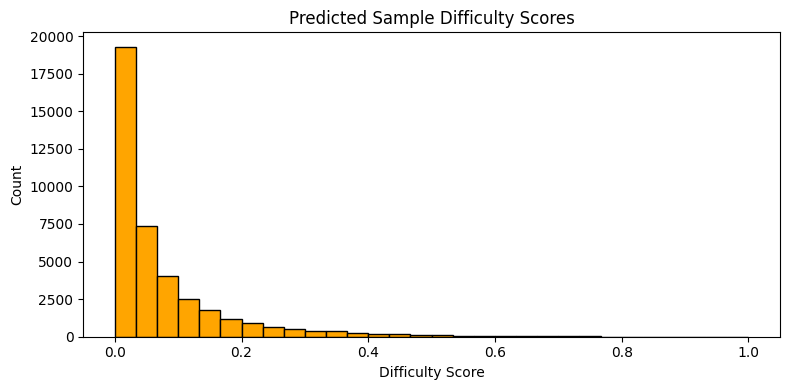

: 

In [ ]:
# Plot and save histogram
import matplotlib.pyplot as plt

# Load scores
scores = np.load("difficulty_scores_new.npy")
print(scores)
print(scores.min())
print(scores.max())
#scores = data["difficulties"]

plt.figure(figsize=(8, 4))
plt.hist(scores, bins=30, color='orange', edgecolor='black')
plt.title("Predicted Sample Difficulty Scores")
plt.xlabel("Difficulty Score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("difficulty_histogram.png")
plt.show()